# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [2]:
! pip install SimpleITK 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.4 MB/s eta 0:00:00


### Downloading the data

In [1]:
!wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
!unzip brainage-data.zip

--2023-02-27 08:28:20--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  30.1MB/s    in 16s     

2023-02-27 08:28:36 (28.7 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating: data

### Setting data directory

In [3]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [4]:

# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

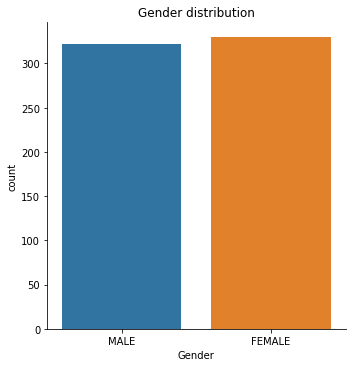

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


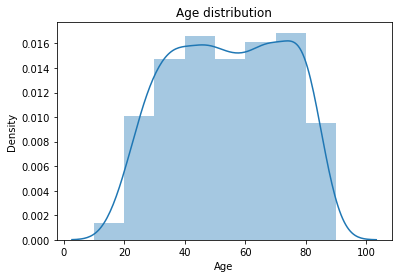

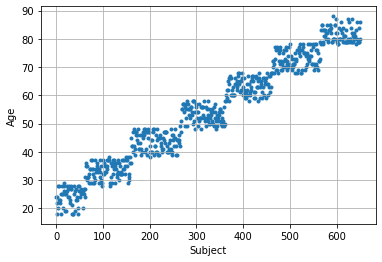

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [6]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


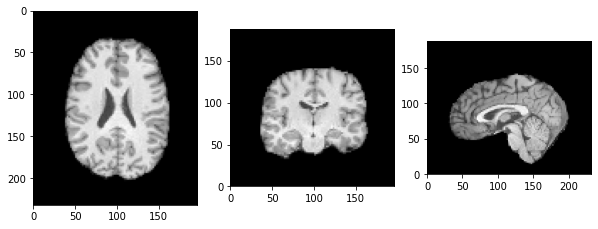

Brain mask


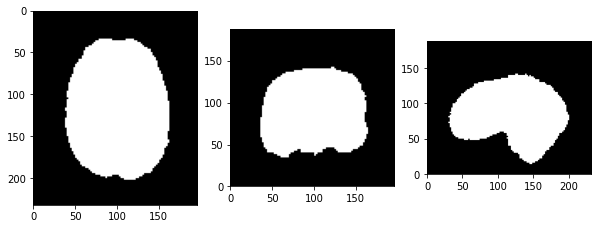

In [7]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [9]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [10]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [11]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 30
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [12]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [13]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


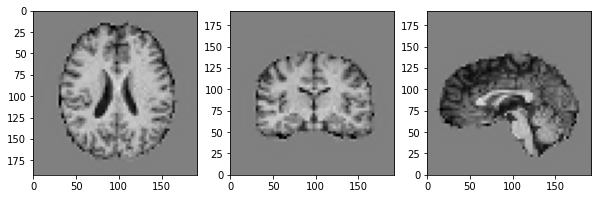

Segmentation


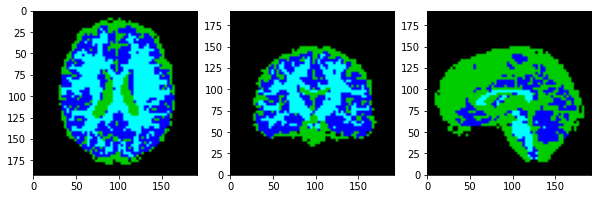

Mask


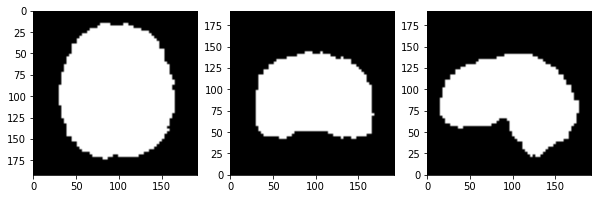

In [14]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

## The SimpleNet3D (unchanged)

In [15]:
########################################
# BUILD A BETTER MODEL HERE
########################################



# This is the original SimpleNet3D
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        
        return x # cross-entropy loss expects raw logits and applies softmax




#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

Total number of parameters in the UNet_variant: 548


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.148323
+ Validation Loss: 1.1407
Validation dice scores per segment
Background:0.901199996471405
CSF:0.0
GM:0.00039999998989515007
WM:0.7050999999046326
average dice score: 0.40167510509490967
show the prediction picture


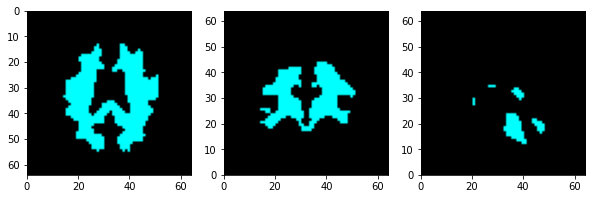

+ TRAINING 	Epoch: 2 	Loss: 0.860434
+ TRAINING 	Epoch: 3 	Loss: 0.584151
+ TRAINING 	Epoch: 4 	Loss: 0.459441
+ TRAINING 	Epoch: 5 	Loss: 0.360636
+ TRAINING 	Epoch: 6 	Loss: 0.344383
+ TRAINING 	Epoch: 7 	Loss: 0.298388
+ TRAINING 	Epoch: 8 	Loss: 0.316108
+ TRAINING 	Epoch: 9 	Loss: 0.305934
+ TRAINING 	Epoch: 10 	Loss: 0.253367
+ Validation Loss: 0.2715
Validation dice scores per segment
Background:0.9761000275611877
CSF:0.5705000162124634
GM:0.5982999801635742
WM:0.7544000148773193
average dice score: 0.7248333692550659
show the prediction picture


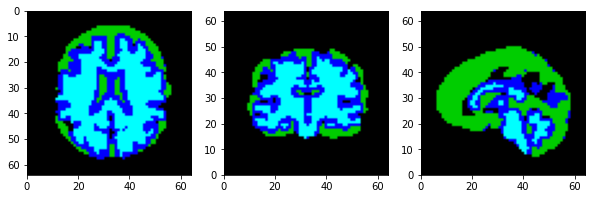

+ TRAINING 	Epoch: 11 	Loss: 0.266114
+ TRAINING 	Epoch: 12 	Loss: 0.279363
+ TRAINING 	Epoch: 13 	Loss: 0.241790
+ TRAINING 	Epoch: 14 	Loss: 0.265245
+ TRAINING 	Epoch: 15 	Loss: 0.232024
+ TRAINING 	Epoch: 16 	Loss: 0.238017
+ TRAINING 	Epoch: 17 	Loss: 0.265302
+ TRAINING 	Epoch: 18 	Loss: 0.261625
+ TRAINING 	Epoch: 19 	Loss: 0.259011
+ TRAINING 	Epoch: 20 	Loss: 0.260201
+ Validation Loss: 0.2378
Validation dice scores per segment
Background:0.9805999994277954
CSF:0.5925999879837036
GM:0.659500002861023
WM:0.7900000214576721
average dice score: 0.7556806206703186
show the prediction picture


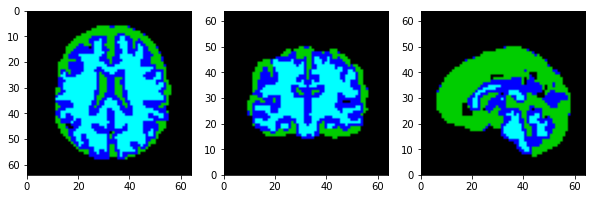

+ TRAINING 	Epoch: 21 	Loss: 0.259688
+ TRAINING 	Epoch: 22 	Loss: 0.205773
+ TRAINING 	Epoch: 23 	Loss: 0.219309
+ TRAINING 	Epoch: 24 	Loss: 0.248772
+ TRAINING 	Epoch: 25 	Loss: 0.219500
+ TRAINING 	Epoch: 26 	Loss: 0.217930
+ TRAINING 	Epoch: 27 	Loss: 0.207957
+ TRAINING 	Epoch: 28 	Loss: 0.224893
+ TRAINING 	Epoch: 29 	Loss: 0.244853
+ TRAINING 	Epoch: 30 	Loss: 0.273141
+ Validation Loss: 0.2191
Validation dice scores per segment
Background:0.9811999797821045
CSF:0.5777000188827515
GM:0.7099000215530396
WM:0.8091999888420105
average dice score: 0.7694693803787231
show the prediction picture


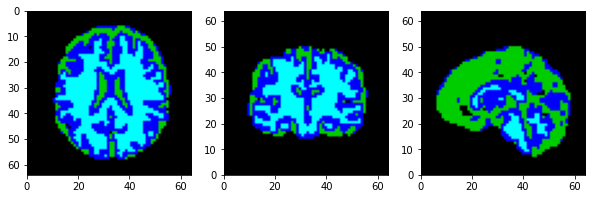


Finished TRAINING.


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


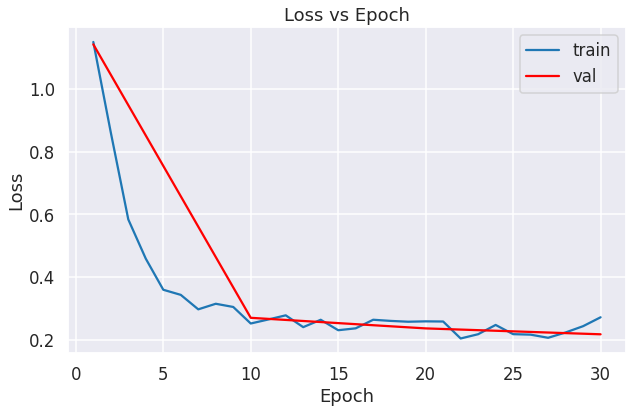

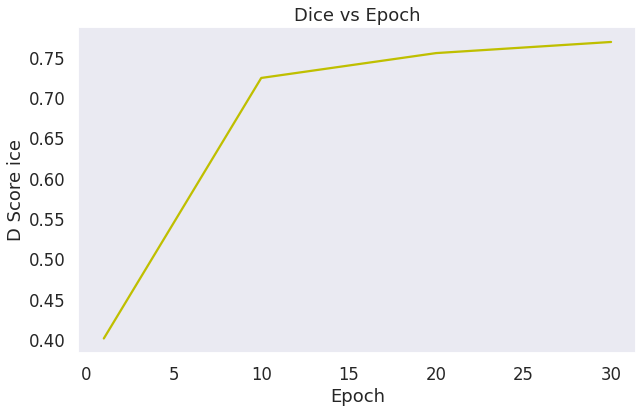

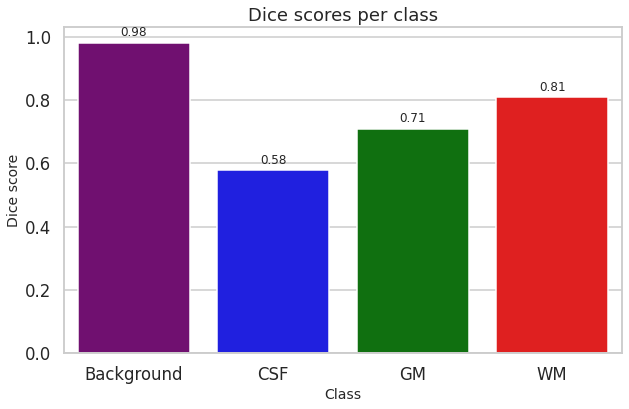

Lowest training loss: 0.2058
Lowest validation loss: 0.2191
Highest average dice score: 0.7695


In [ ]:
from sklearn.metrics import f1_score

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


model_dir = os.path.join(out_dir, 'model_simple')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed


model = SimpleNet3D(num_classes=num_classes).to(device)
model.apply(weights_init)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the UNet_variant: {}".format(params))
print('\n')

model.train()
    
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
average_dice_validation_log = []

print('START TRAINING...')

for epoch in range(1, num_epochs + 1):
    model.train()
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img = batch_samples['img'].to(device)
        seg = batch_samples['seg'].to(device)

        optimizer.zero_grad()
        prd = model(img)

        prd_flat = prd.view(prd.size(0), prd.size(1), -1)

        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))

        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()
        loss_val = 0
        sum_pts = 0
        idx_val = 0
        dice_val = 0
        dice_scores = []
        with torch.no_grad():
          for data_sample in dataloader_val:
            img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1)
            loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)

            ################### calculate dice ###########################
            label = seg.cpu().squeeze(1)
            labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            labels = labels.view(labels.size(0), labels.size(1), -1)

            pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            pred = pred.view(pred.size(0), pred.size(1), -1)
            
            intersection = (labels * pred).sum(-1) 
            denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

            dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-8))

            dice_val += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            idx_val += 1
        
        

        loss_val /= sum_pts
        dice_val /= idx_val
        dice_val = dice_val.squeeze()
        print('+ Validation Loss: {:.4f}'.format(loss_val))
        print(f'Validation dice scores per segment')
        print(f'Background:{torch.round(dice_val[0],decimals=4)}')
        print(f'CSF:{torch.round(dice_val[1],decimals=4)}')
        print(f'GM:{torch.round(dice_val[2],decimals=4)}')
        print(f'WM:{torch.round(dice_val[3],decimals=4)}')
        

        mean_dice_val = torch.mean(dice_val)
        
        print(f'average dice score: {mean_dice_val}')
        print('show the prediction picture')
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        display_image(sitk.LabelToRGB(prediction, sitk.sitkInt8))

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        average_dice_validation_log.append(mean_dice_val)
            
torch.save(model.state_dict(), os.path.join(model_dir, 'model_simple.pt'))

print('\nFinished TRAINING.')

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")
# Increase plot size
plt.figure(figsize=(10, 6))
sns.lineplot(range(1, num_epochs + 1), loss_train_log, label='train')
sns.lineplot(epoch_val_log, loss_val_log, label='val',color='red')
loss_train_log_simple=loss_train_log
loss_val_log_simple=loss_val_log
# Add a title to the sns plot
plt.title('Loss vs Epoch')
# Add a label to the x axis
plt.xlabel('Epoch')
# Add a label to the y axis
plt.ylabel('Loss')
# Add a legend
plt.legend()
# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.set_context("talk")
plt.title('Dice vs Epoch')
plt.plot(epoch_val_log, average_dice_validation_log, c='y', label='dice')
average_dice_validation_log_simple=average_dice_validation_log
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('D Score ice')
plt.show()


sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=['Background', 'CSF', 'GM', 'WM'], y=dice_val.tolist(), ax=ax, palette=['purple', 'blue', 'green', 'red'])
dice_val_simple=dice_val
ax.set_title('Dice scores per class', fontsize=18)#['#4b0082', '#0000ff', '#008000', '#ff0000']
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Dice score', fontsize=14)

# Add text labels to the bars
for i, v in enumerate(dice_val):
    ax.text(i, v + 0.02, "{:.2f}".format(v), ha='center', fontsize=12)

plt.show()
print(f'Lowest training loss: {round(min(loss_train_log),4)}')
print(f'Lowest validation loss: {round(min(loss_val_log),4)}')
print(f'Highest average dice score: {round(float(average_dice_validation_log[-1]),4)}')

# Modified U-Net

In [ ]:
in_channels=1
out_channels=32
########################################
# BUILD A BETTER MODEL HERE
########################################
"""
Architecture adapted from "https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705"
"""

class UNet_variant(nn.Module):

    def __init__(self, num_classes):
        super(UNet_variant, self).__init__()

        # reduce image dimensions
        self.contract_block_1 = nn.Sequential(
          nn.Conv3d(1, out_channels, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),

          nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels),
          nn.ReLU(inplace=True)
          )
        self.contract_block_2 = nn.Sequential(
          nn.Conv3d(out_channels, out_channels*2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels*2),
          nn.ReLU(inplace=True),

          nn.Conv3d(out_channels*2, out_channels*2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels*2),
          nn.ReLU(inplace=True)
          )
        
        self.contract_block_3 = nn.Sequential(
          nn.Conv3d(out_channels*2, out_channels*4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels*4),
          nn.ReLU(inplace=True),
          nn.Conv3d(out_channels*4, out_channels*4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels*4),
          nn.ReLU(inplace=True)
          )  
        
        # bottle neck
        self.expand_block = nn.Sequential(
          nn.Conv3d(out_channels*4, out_channels*8, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels*8),
          nn.ReLU(inplace=True),
          nn.Conv3d(out_channels*8, out_channels*8, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_channels*8),
          nn.ReLU(inplace=True)
        )

        self.contract_block_4 = nn.Sequential(
            nn.ConvTranspose3d(out_channels*8, out_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(out_channels*4))
        
        self.contract_block_5 = nn.Sequential(
            nn.Conv3d(out_channels*8, out_channels*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels*4),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels*4, out_channels*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels*4),
            nn.ReLU(inplace=True))
        
        self.contract_block_6 = nn.Sequential(
            nn.ConvTranspose3d(out_channels*4, out_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(out_channels*2))
        

        self.contract_block_7 = nn.Sequential(
            nn.Conv3d(out_channels*4, out_channels*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels*2, out_channels*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels*2),
            nn.ReLU(inplace=True))
        
        self.contract_block_8 = nn.Sequential(
            nn.ConvTranspose3d(out_channels*2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(out_channels))
        self.contract_block_9 = nn.Sequential(
            nn.Conv3d(out_channels*2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True))

        # reduce the number of feature maps
        self.contract_block_10 = nn.Sequential(
            nn.Conv3d(out_channels, num_classes, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        fm1 = self.contract_block_1(x)
        x = F.max_pool3d(fm1, kernel_size=2, stride=2)

        fm2 = self.contract_block_2(x)
        x = F.max_pool3d(fm2, kernel_size=2, stride=2)

        fm3 = self.contract_block_3(x)
        x = F.max_pool3d(fm3, kernel_size=2, stride=2)

        # bottle neck
        x = self.expand_block(x)

        # increase image dimensions
        x = self.contract_block_4(x)
        x = torch.cat([x,fm3], dim=1)
        x = self.contract_block_5(x)

        x = self.contract_block_6(x)
        x = torch.cat([x, fm2], dim=1)
        x = self.contract_block_7(x)

        x = self.contract_block_8(x)
        x = torch.cat([x, fm1], dim=1)
        x = self.contract_block_9(x)

        # reduce the number of feature maps
        x = self.contract_block_10(x)

        
        return x # cross-entropy loss expects raw logits and applies softmax


Total number of parameters in the UNet_variant: 8011460


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.878863
+ Validation Loss: 0.9198
Validation dice scores per segment
Background:0.8752
CSF:0.0
GM:0.0
WM:0.0
average dice score: 0.21880725026130676
show the prediction picture


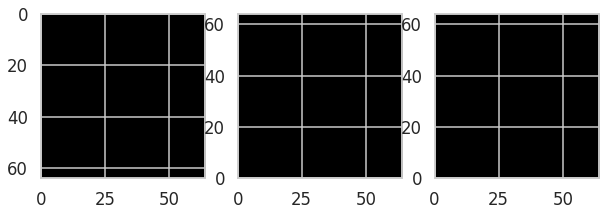

+ TRAINING 	Epoch: 2 	Loss: 0.590752
+ TRAINING 	Epoch: 3 	Loss: 0.415496
+ TRAINING 	Epoch: 4 	Loss: 0.291685
+ TRAINING 	Epoch: 5 	Loss: 0.224284
+ TRAINING 	Epoch: 6 	Loss: 0.200647
+ TRAINING 	Epoch: 7 	Loss: 0.172365
+ TRAINING 	Epoch: 8 	Loss: 0.140675
+ TRAINING 	Epoch: 9 	Loss: 0.122782
+ TRAINING 	Epoch: 10 	Loss: 0.144166
+ Validation Loss: 0.1903
Validation dice scores per segment
Background:0.9836
CSF:0.6648
GM:0.7318
WM:0.9066
average dice score: 0.8216938972473145
show the prediction picture


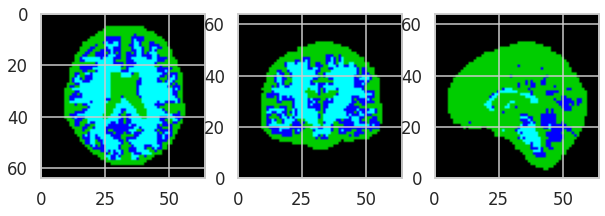

+ TRAINING 	Epoch: 11 	Loss: 0.118162
+ TRAINING 	Epoch: 12 	Loss: 0.105096
+ TRAINING 	Epoch: 13 	Loss: 0.090625
+ TRAINING 	Epoch: 14 	Loss: 0.116375
+ TRAINING 	Epoch: 15 	Loss: 0.122169
+ TRAINING 	Epoch: 16 	Loss: 0.089856
+ TRAINING 	Epoch: 17 	Loss: 0.090348
+ TRAINING 	Epoch: 18 	Loss: 0.079456
+ TRAINING 	Epoch: 19 	Loss: 0.086456
+ TRAINING 	Epoch: 20 	Loss: 0.073154
+ Validation Loss: 0.1238
Validation dice scores per segment
Background:0.9884
CSF:0.7684
GM:0.8334
WM:0.9083
average dice score: 0.8746236562728882
show the prediction picture


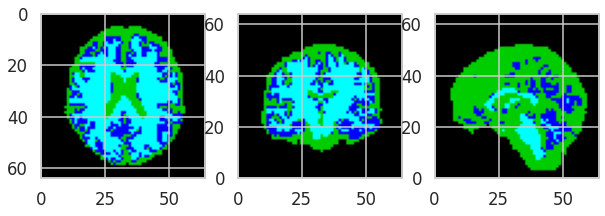

+ TRAINING 	Epoch: 21 	Loss: 0.077469
+ TRAINING 	Epoch: 22 	Loss: 0.071144
+ TRAINING 	Epoch: 23 	Loss: 0.085606
+ TRAINING 	Epoch: 24 	Loss: 0.131655
+ TRAINING 	Epoch: 25 	Loss: 0.071752
+ TRAINING 	Epoch: 26 	Loss: 0.065250
+ TRAINING 	Epoch: 27 	Loss: 0.072497
+ TRAINING 	Epoch: 28 	Loss: 0.134577
+ TRAINING 	Epoch: 29 	Loss: 0.067614
+ TRAINING 	Epoch: 30 	Loss: 0.101799
+ Validation Loss: 0.0762
Validation dice scores per segment
Background:0.992
CSF:0.8202
GM:0.9027
WM:0.9288
average dice score: 0.9109370708465576
show the prediction picture


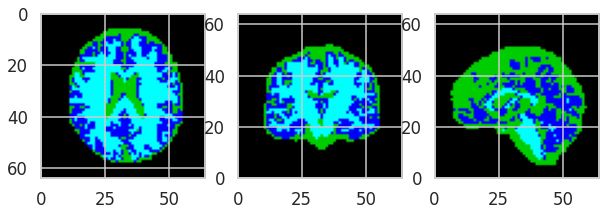


Finished TRAINING.


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


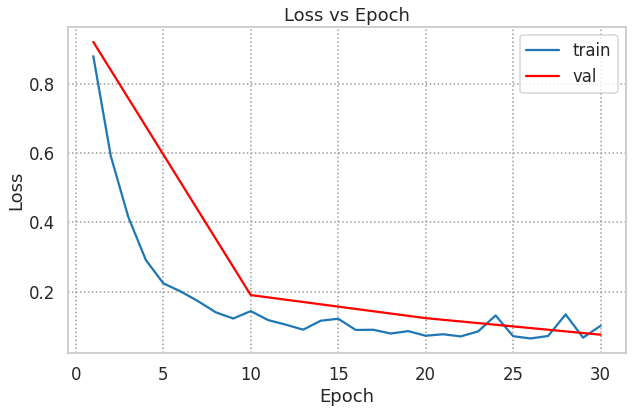

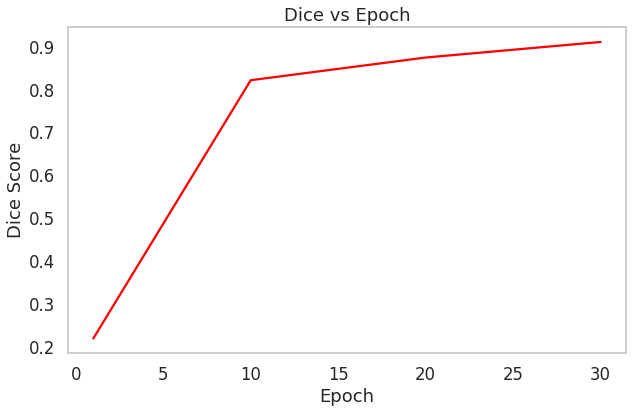

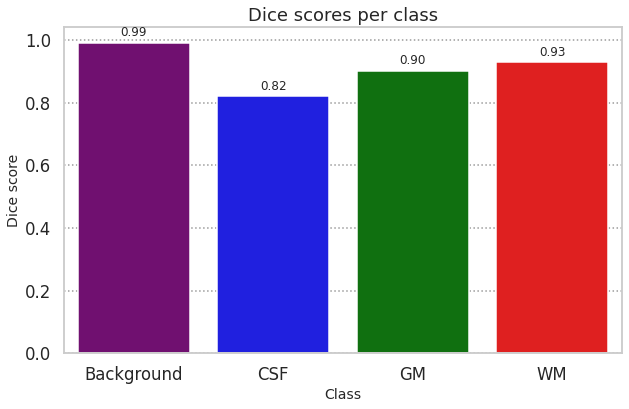

Lowest training loss: 0.0653
Lowest validation loss: 0.0762
Highest average dice score: 0.9109


In [ ]:
from sklearn.metrics import f1_score

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


model_dir = os.path.join(out_dir, 'model_UNet')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)



torch.manual_seed(rnd_seed) #fix random seed


model = UNet_variant(num_classes=num_classes).to(device)
model.apply(weights_init)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the UNet_variant: {}".format(params))
print('\n')

model.train()
    
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
average_dice_validation_log = []

print('START TRAINING...')

for epoch in range(1, num_epochs + 1):
    model.train()
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img = batch_samples['img'].to(device)
        seg = batch_samples['seg'].to(device)

        optimizer.zero_grad()
        prd = model(img)

        prd_flat = prd.view(prd.size(0), prd.size(1), -1)

        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))

        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()
        loss_val = 0
        sum_pts = 0
        idx_val = 0
        dice_val = 0
        dice_scores = []
        with torch.no_grad():
          for data_sample in dataloader_val:
            img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1)
            loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)

            ################### calculate dice ###########################
            label = seg.cpu().squeeze(1)
            labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            labels = labels.view(labels.size(0), labels.size(1), -1)

            pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            pred = pred.view(pred.size(0), pred.size(1), -1)
            
            intersection = (labels * pred).sum(-1) 
            denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

            dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-8))

            dice_val += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            idx_val += 1
        
        

        loss_val /= sum_pts
        dice_val /= idx_val
        dice_val = dice_val.squeeze()
        print('+ Validation Loss: {:.4f}'.format(loss_val))
        print(f'Validation dice scores per segment')
        print(f'Background:{round(float(dice_val[0]),4)}')
        print(f'CSF:{round(float(dice_val[1]),4)}')
        print(f'GM:{round(float(dice_val[2]),4)}')
        print(f'WM:{round(float(dice_val[3]),4)}')
        
       

        mean_dice_val = torch.mean(dice_val)
        
        print(f'average dice score: {mean_dice_val}')
        print('show the prediction picture')
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        display_image(sitk.LabelToRGB(prediction, sitk.sitkInt8))

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        average_dice_validation_log.append(mean_dice_val)
            
torch.save(model.state_dict(), os.path.join(model_dir, 'model_UNet.pt'))

print('\nFinished TRAINING.')

import seaborn as sns
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")
# Increase plot size
plt.figure(figsize=(10, 6))
sns.lineplot(range(1, num_epochs + 1), loss_train_log, label='train')
loss_train_log_UNet=loss_train_log
sns.lineplot(epoch_val_log, loss_val_log, label='val',color='red')
loss_val_log_UNet=loss_val_log
# Add a title to the sns plot
plt.title('Loss vs Epoch')
# Add a label to the x axis
plt.xlabel('Epoch')
# Add a label to the y axis
plt.ylabel('Loss')
# Add a legend
plt.legend()
# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")
plt.title('Dice vs Epoch')
plt.plot(epoch_val_log, average_dice_validation_log, c='r', label='dice')
average_dice_validation_log_UNet=average_dice_validation_log
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.show()


sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=['Background', 'CSF', 'GM', 'WM'], y=dice_val.tolist(), ax=ax, palette=['purple', 'blue', 'green', 'red'])
dice_val_UNet=dice_val
ax.set_title('Dice scores per class', fontsize=18)#['#4b0082', '#0000ff', '#008000', '#ff0000']
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Dice score', fontsize=14)

# Add text labels to the bars
for i, v in enumerate(dice_val):
    ax.text(i, v + 0.02, "{:.2f}".format(v), ha='center', fontsize=12)

plt.show()
print(f'Lowest training loss: {round(min(loss_train_log),4)}')
print(f'Lowest validation loss: {round(min(loss_val_log),4)}')
print(f'Highest average dice score: {round(float(average_dice_validation_log[-1]),4)}')

## The SimpleNet3D (Deeper)

In [36]:
#this is the updated Simple 3Dnet 
out_channels = 10
########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D_modified(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D_modified, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv3d(1, out_channels*2, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm3d(out_channels*2)

        self.conv2 = nn.Conv3d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm3d(out_channels*4)

        self.conv3 = nn.Conv3d(4*out_channels, 6*out_channels, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm3d(out_channels*6)

        self.conv4 = nn.Conv3d(6*out_channels, 4*out_channels, kernel_size=1)
        self.conv4_bn = nn.BatchNorm3d(out_channels*4)

        self.conv5 = nn.Conv3d(4*out_channels, out_channels*2, kernel_size=1)
        self.conv5_bn = nn.BatchNorm3d(out_channels*2)

        self.conv6 = nn.Conv3d(2*out_channels, num_classes, kernel_size=1)



    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))

        x = F.relu(self.conv2_bn(self.conv2(x)))

        x = F.relu(self.conv3_bn(self.conv3(x)))

        x = F.relu(self.conv4_bn(self.conv4(x)))

        x = F.relu(self.conv5_bn(self.conv5(x)))

        x = self.conv6(x)
        return F.softmax(x, dim=1)



Total number of parameters in the in the simple 3DNet(Deeper): 90764


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.283137
+ Validation Loss: 1.3345
Validation dice scores per segment
Background:0.8751999735832214
CSF:0.0
GM:0.0
WM:0.0
average dice score: 0.21880725026130676
show the prediction picture


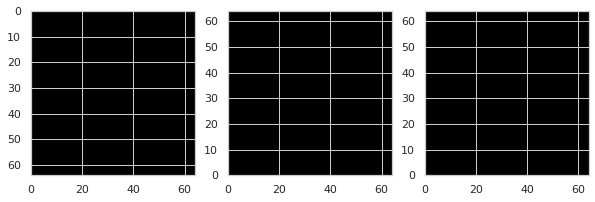

+ TRAINING 	Epoch: 2 	Loss: 1.187472
+ TRAINING 	Epoch: 3 	Loss: 1.099356
+ TRAINING 	Epoch: 4 	Loss: 1.025492
+ TRAINING 	Epoch: 5 	Loss: 0.967009
+ TRAINING 	Epoch: 6 	Loss: 0.915201
+ TRAINING 	Epoch: 7 	Loss: 0.883670
+ TRAINING 	Epoch: 8 	Loss: 0.863341
+ TRAINING 	Epoch: 9 	Loss: 0.841227
+ TRAINING 	Epoch: 10 	Loss: 0.834162
+ Validation Loss: 0.8306
Validation dice scores per segment
Background:0.9879999756813049
CSF:0.7645999789237976
GM:0.8659999966621399
WM:0.871999979019165
average dice score: 0.8726529479026794
show the prediction picture


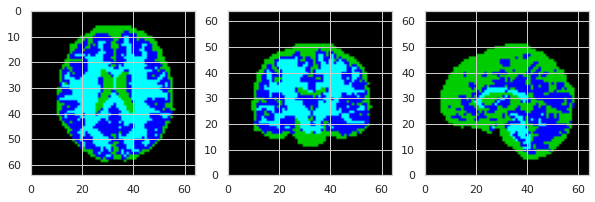

+ TRAINING 	Epoch: 11 	Loss: 0.820757
+ TRAINING 	Epoch: 12 	Loss: 0.813756
+ TRAINING 	Epoch: 13 	Loss: 0.805914
+ TRAINING 	Epoch: 14 	Loss: 0.803261
+ TRAINING 	Epoch: 15 	Loss: 0.798099
+ TRAINING 	Epoch: 16 	Loss: 0.804475
+ TRAINING 	Epoch: 17 	Loss: 0.794442
+ TRAINING 	Epoch: 18 	Loss: 0.796047
+ TRAINING 	Epoch: 19 	Loss: 0.812313
+ TRAINING 	Epoch: 20 	Loss: 0.791466
+ Validation Loss: 0.7903
Validation dice scores per segment
Background:0.9900000095367432
CSF:0.7811999917030334
GM:0.8736000061035156
WM:0.8949999809265137
average dice score: 0.884953498840332
show the prediction picture


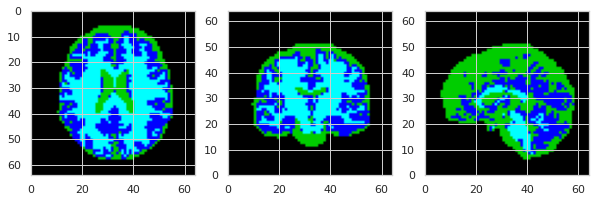

+ TRAINING 	Epoch: 21 	Loss: 0.788955
+ TRAINING 	Epoch: 22 	Loss: 0.794643
+ TRAINING 	Epoch: 23 	Loss: 0.794127
+ TRAINING 	Epoch: 24 	Loss: 0.787172
+ TRAINING 	Epoch: 25 	Loss: 0.806593
+ TRAINING 	Epoch: 26 	Loss: 0.783641
+ TRAINING 	Epoch: 27 	Loss: 0.785242
+ TRAINING 	Epoch: 28 	Loss: 0.787554
+ TRAINING 	Epoch: 29 	Loss: 0.782593
+ TRAINING 	Epoch: 30 	Loss: 0.786428
+ Validation Loss: 0.7871
Validation dice scores per segment
Background:0.9904000163078308
CSF:0.7749000191688538
GM:0.8687999844551086
WM:0.8970000147819519
average dice score: 0.8827606439590454
show the prediction picture


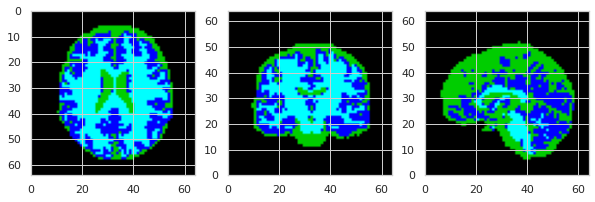


Finished TRAINING.


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


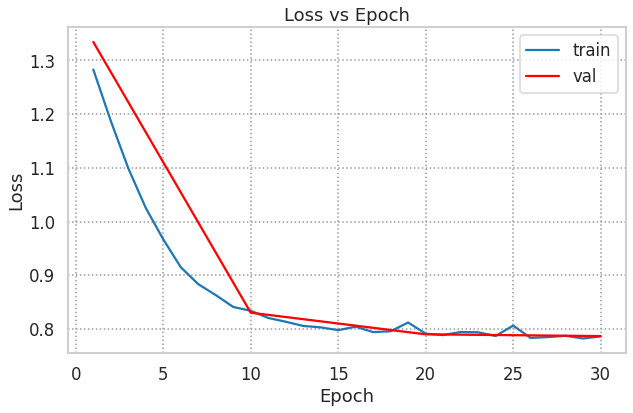

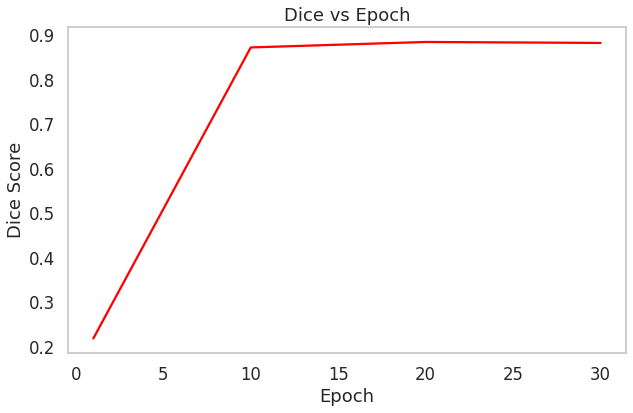

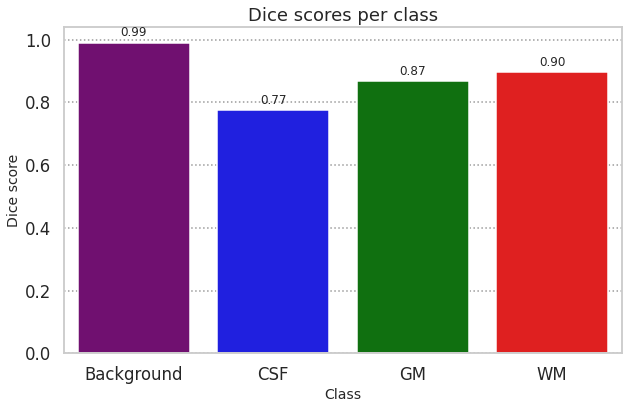

Lowest training loss: 0.7826
Lowest validation loss: 0.7871
Highest average dice score: 0.8828


In [37]:
from sklearn.metrics import f1_score

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed


model = SimpleNet3D_modified(num_classes=num_classes).to(device)
model.apply(weights_init)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the in the simple 3DNet(Deeper): {}".format(params))
print('\n')

model.train()
    
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
average_dice_validation_log = []

print('START TRAINING...')

for epoch in range(1, num_epochs + 1):
    model.train()
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img = batch_samples['img'].to(device)
        seg = batch_samples['seg'].to(device)

        optimizer.zero_grad()
        prd = model(img)

        prd_flat = prd.view(prd.size(0), prd.size(1), -1)

        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))

        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()
        loss_val = 0
        sum_pts = 0
        idx_val = 0
        dice_val = 0
        dice_scores = []
        with torch.no_grad():
          for data_sample in dataloader_val:
            img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1)
            loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)

            ################### calculate dice ###########################
            label = seg.cpu().squeeze(1)
            labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            labels = labels.view(labels.size(0), labels.size(1), -1)

            pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            pred = pred.view(pred.size(0), pred.size(1), -1)
            
            intersection = (labels * pred).sum(-1) 
            denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

            dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-8))

            dice_val += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            idx_val += 1
        
        

        loss_val /= sum_pts
        dice_val /= idx_val
        dice_val = dice_val.squeeze()
        print('+ Validation Loss: {:.4f}'.format(loss_val))
        print(f'Validation dice scores per segment')
        print(f'Background:{torch.round(dice_val[0],decimals=4)}')
        print(f'CSF:{torch.round(dice_val[1],decimals=4)}')
        print(f'GM:{torch.round(dice_val[2],decimals=4)}')
        print(f'WM:{torch.round(dice_val[3],decimals=4)}')
        

        mean_dice_val = torch.mean(dice_val)
        
        print(f'average dice score: {mean_dice_val}')
        print('show the prediction picture')
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        display_image(sitk.LabelToRGB(prediction, sitk.sitkInt8))

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        average_dice_validation_log.append(mean_dice_val)
            
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

import seaborn as sns
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")
# Increase plot size
plt.figure(figsize=(10, 6))
sns.lineplot(range(1, num_epochs + 1), loss_train_log, label='train')
loss_train_log_simple_deeper=loss_train_log
sns.lineplot(epoch_val_log, loss_val_log, label='val',color='red')
loss_val_log_simple_deeper=loss_val_log
# Add a title to the sns plot
plt.title('Loss vs Epoch')
# Add a label to the x axis
plt.xlabel('Epoch')
# Add a label to the y axis
plt.ylabel('Loss')
# Add a legend
plt.legend()
# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")
plt.title('Dice vs Epoch')
plt.plot(epoch_val_log, average_dice_validation_log, c='r', label='dice')
average_dice_validation_log_simple_deeper=average_dice_validation_log
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.show()


sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=['Background', 'CSF', 'GM', 'WM'], y=dice_val.tolist(), ax=ax, palette=['purple', 'blue', 'green', 'red'])
dice_val_simple_deeper=dice_val
ax.set_title('Dice scores per class', fontsize=18)#['#4b0082', '#0000ff', '#008000', '#ff0000']
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Dice score', fontsize=14)

# Add text labels to the bars
for i, v in enumerate(dice_val):
    ax.text(i, v + 0.02, "{:.2f}".format(v), ha='center', fontsize=12)

plt.show()
print(f'Lowest training loss: {round(min(loss_train_log),4)}')
print(f'Lowest validation loss: {round(min(loss_val_log),4)}')
print(f'Highest average dice score: {round(float(average_dice_validation_log[-1]),4)}')

# Comparing SimpleNet vs UNet

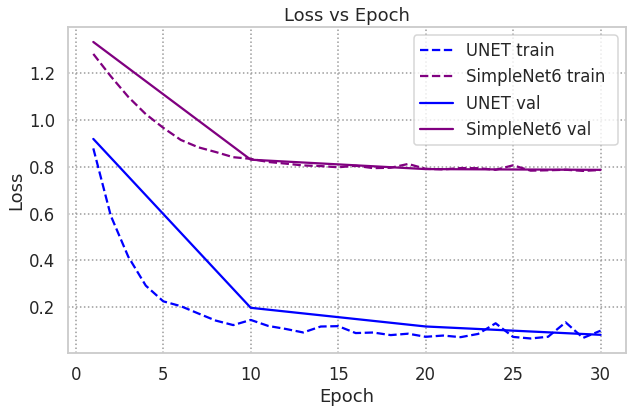

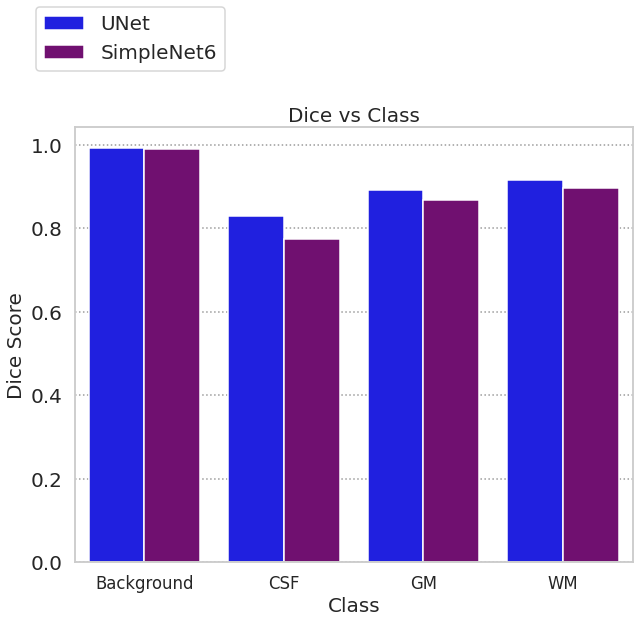

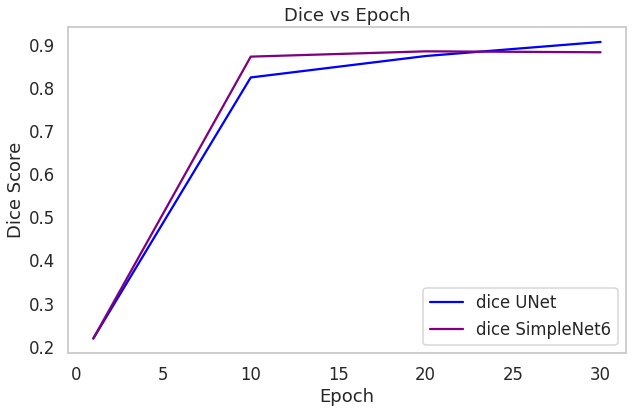

In [ ]:
import seaborn as sns
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")
# Increase plot size
plt.figure(figsize=(10, 6))
sns.lineplot(range(1, num_epochs + 1), loss_train_log_UNet, label='UNET train ',color='blue',linestyle="dashed")
sns.lineplot(range(1, num_epochs + 1), loss_train_log_simple_deeper, label='SimpleNet6 train ',color='purple',linestyle="dashed")

sns.lineplot(epoch_val_log, loss_val_log_UNet, label='UNET val ',color='blue')
sns.lineplot(epoch_val_log, loss_val_log_simple_deeper, label='SimpleNet6 val ',color='purple')

# Add a title to the sns plot
plt.title('Loss vs Epoch')
# Add a label to the x axis
plt.xlabel('Epoch')
# Add a label to the y axis
plt.ylabel('Loss')
# Add a legend
plt.legend()
# Show the plot
plt.show()

##Plot the Dice scores

import seaborn as sns
import pandas as pd

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the two datasets into a single dataframe
data = pd.DataFrame({
    'Class': ['Background', 'CSF', 'GM', 'WM'],
    'UNet': dice_val_UNet.tolist(),
    'SimpleNet6': dice_val_simple_deeper.tolist()
})

# Melt the dataframe to convert the data from wide to long format
data_melted = data.melt('Class', var_name='Model', value_name='Dice Score')

# Convert the Dice Score column to a numeric format
data_melted['Dice Score'] = pd.to_numeric(data_melted['Dice Score'])

# Plot the bar chart using sns.barplot()
sns.barplot(x='Class', y='Dice Score', hue='Model', data=data_melted, palette=['b', 'purple'])

ax.set_title('Dice vs Class',fontsize = 20)
ax.set_xlabel('Class',fontsize = 20)
ax.set_ylabel('Dice Score',fontsize = 20)
ax.legend(title='Model',fontsize = 20)
plt.yticks(fontsize = 20)
ax.legend(fontsize = 20,loc='upper center', bbox_to_anchor=(0.1, 1.3))

plt.show()

### plotting dice avergae score

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("talk")
plt.title('Dice vs Epoch')
plt.plot(epoch_val_log, average_dice_validation_log_UNet, c='b', label='dice UNet')
plt.plot(epoch_val_log, average_dice_validation_log_simple_deeper, c='purple', label='dice SimpleNet6')

average_dice_validation_log_UNet=average_dice_validation_log
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.show()



#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [38]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


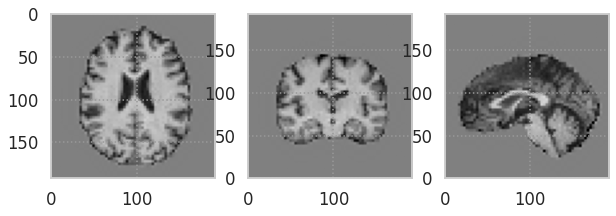

Segmentation


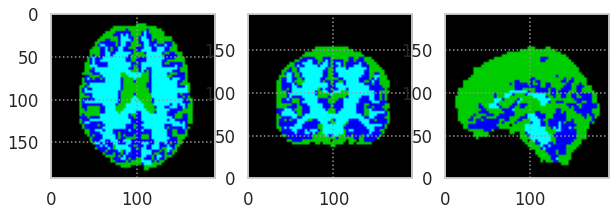

Mask


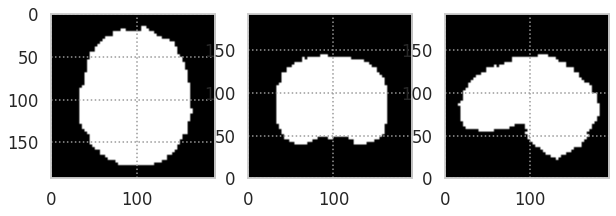

In [39]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.792351
Test dice scores per segment
Background:0.9896
CSF:0.7567
GM:0.8436
WM:0.8885
Average dice scores: 0.8696


Reference segmentation


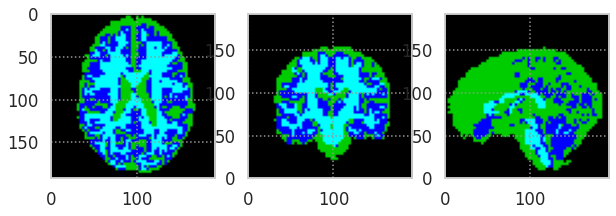

Predicted segmentation


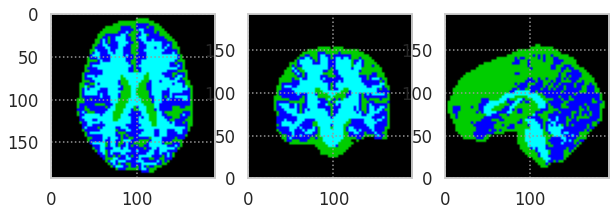


Finished TESTING.


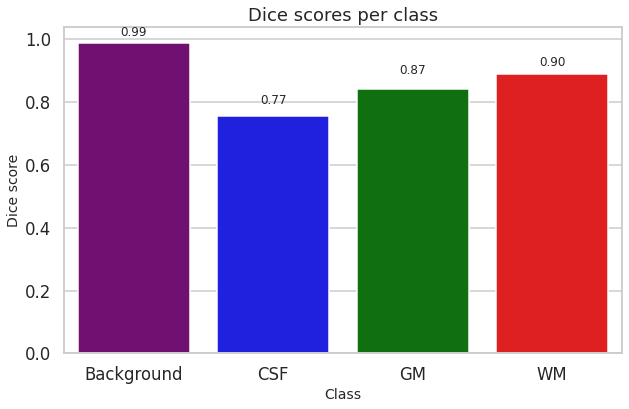

In [40]:

pred_dir = os.path.join(out_dir, 'pred')
model_dir = os.path.join(out_dir, 'model')

if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

#Run SimpleNet6
model = SimpleNet3D_modified(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))

# Run the simpleNet, First run the training loop for Simplenet
# model = SimpleNet3D(num_classes=num_classes)
# model.load_state_dict(torch.load(os.path.join('./output/model_simple', 'model_simple.pt')))

# Run the UNet, First run the training loop for UNET
# model = UNet_variant(num_classes=num_classes)
# model.load_state_dict(torch.load(os.path.join('./output/model_UNet', 'model_UNet.pt')))


model.to(device)
model.eval()


print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_test=0
dice_test_scores=[]
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))


        ## dice score
        label = seg.cpu().squeeze(1)
        labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
        labels = labels.view(labels.size(0), labels.size(1), -1)

        pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
        pred = pred.view(pred.size(0), pred.size(1), -1)
        
        intersection = (labels * pred).sum(-1) 
        denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

        dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-6))

        dice_test += dice_score_per_channel
        dice_test_scores.append(dice_score_per_channel.numpy().tolist())

        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
dice_test /= idx_test
dice_test = dice_test.squeeze()
print(f'Test dice scores per segment')
print(f'Background:{round(float(dice_test[0]),4)}')
print(f'CSF:{round(float(dice_test[1]),4)}')
print(f'GM:{round(float(dice_test[2]),4)}')
print(f'WM:{round(float(dice_test[3]),4)}')
print(f'Average dice scores: {round(float(torch.mean(dice_test)),4)}')



# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=['Background', 'CSF', 'GM', 'WM'], y=dice_test.tolist(), ax=ax, palette=['purple', 'blue', 'green', 'red'])
ax.set_title('Dice scores per class', fontsize=18)#['#4b0082', '#0000ff', '#008000', '#ff0000']
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Dice score', fontsize=14)

# Add text labels to the bars
for i, v in enumerate(dice_val):
    ax.text(i, v + 0.02, "{:.2f}".format(v), ha='center', fontsize=12)




#### Visualizations (box plots)

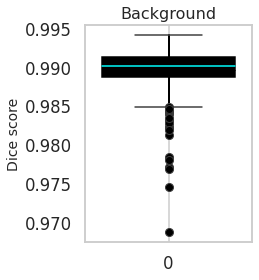

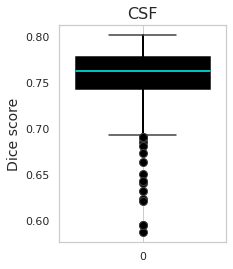

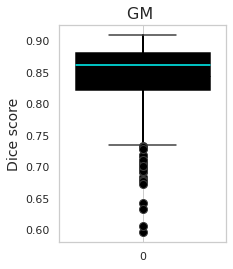

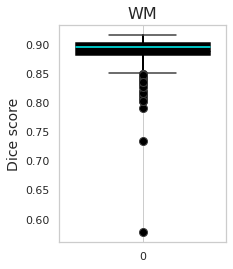

In [41]:


import matplotlib.pyplot as plt


Background_list=[]
CSF_list=[]
GM_list=[]
WM_list=[]
for i in range(len(dice_test_scores)):
  # print(list_1[i][0])
  Background_list.append(dice_test_scores[i][0][0])
  CSF_list.append(dice_test_scores[i][0][1])
  GM_list.append(dice_test_scores[i][0][2])
  WM_list.append(dice_test_scores[i][0][3])


combined_list=[Background_list,CSF_list,GM_list,WM_list]

#Plot Background_list, in a boxplot with labels 'Background' and 'Test' using the sns.boxplot function.
# Define data and labels
data = [Background_list]
labels = ['Background']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(3, 4))

# Set the style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the boxplot
sns.boxplot(data=data, labels=labels, showmeans=True, meanline=True, 
            boxprops=dict(facecolor='cyan', color='black'), 
            medianprops=dict(color='cyan'), meanprops=dict(color='black'), 
            whiskerprops=dict(linewidth=2, color='black'), 
            flierprops=dict(marker='o', markersize=8, markerfacecolor='black'))

# Add gridlines and labels
plt.grid()
# plt.xlabel('Background', fontsize=14)
plt.ylabel('Dice score', fontsize=14)
plt.title('Background', fontsize=16)

# Show the plot
plt.show()

###################################################

# Define data and labels
data = [CSF_list]
labels = ['CSF']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(3, 4))

# Set the style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the boxplot
sns.boxplot(data=data, labels=labels, showmeans=True, meanline=True, 
            boxprops=dict(facecolor='cyan', color='black'), 
            medianprops=dict(color='cyan'), meanprops=dict(color='black'), 
            whiskerprops=dict(linewidth=2, color='black'), 
            flierprops=dict(marker='o', markersize=8, markerfacecolor='black'))

# Add gridlines and labels
plt.grid()
# plt.xlabel('CSF', fontsize=14)
plt.ylabel('Dice score', fontsize=14)
plt.title('CSF', fontsize=16)

# Show the plot
plt.show()


############################################

# Define data and labels
data = [GM_list]
labels = ['GM']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(3, 4))

# Set the style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the boxplot
sns.boxplot(data=data, labels=labels, showmeans=True, meanline=True, 
            boxprops=dict(facecolor='cyan', color='black'), 
            medianprops=dict(color='cyan'), meanprops=dict(color='black'), 
            whiskerprops=dict(linewidth=2, color='black'), 
            flierprops=dict(marker='o', markersize=8, markerfacecolor='black'))

# Add gridlines and labels
plt.grid()
# plt.xlabel('GM', fontsize=14)
plt.ylabel('Dice score', fontsize=14)
plt.title('GM ', fontsize=16)

# Show the plot
plt.show()



############################################

# Define data and labels
data = [WM_list]
labels = ['WM']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(3, 4))

# Set the style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the boxplot
sns.boxplot(data=data, labels=labels, showmeans=True, meanline=True, 
            boxprops=dict(facecolor='cyan', color='black'), 
            medianprops=dict(color='cyan'), meanprops=dict(color='black'), 
            whiskerprops=dict(linewidth=2, color='black'), 
            flierprops=dict(marker='o', markersize=8, markerfacecolor='black'))

# Add gridlines and labels
plt.grid()
# plt.xlabel('Wm', fontsize=14)
plt.ylabel('Dice score', fontsize=14)
plt.title('WM', fontsize=16)

# Show the plot
plt.show()







### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [42]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################

        segmentation_array = sitk.GetArrayFromImage(seg)

        unique, counts = np.unique(segmentation_array, return_counts=True)
        counts_dict = dict(zip(unique, counts))
      
        vols[0, idx] = counts_dict[1] #CSF=1
        vols[1, idx] = counts_dict[2] #GM=2
        vols[2, idx] = counts_dict[3] #WM=3


Calculating Features: 100%|██████████| 500/500 [00:03<00:00, 152.75it/s]


Plot features versus age.

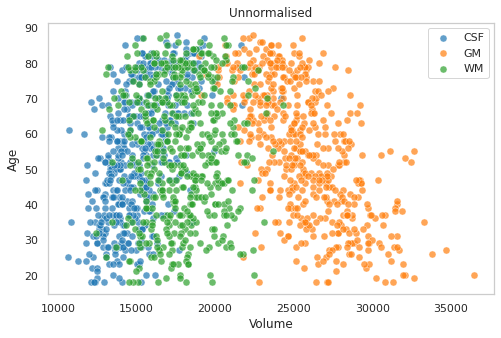

In [43]:
# plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
# plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
# plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
# plt.grid()
# plt.title('Unnormalised')
# plt.xlabel('Volume')
# plt.ylabel('Age')
# plt.legend(('CSF','GM','WM'))
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(x=vols[0,:], y=meta_data_reg_train['age'], marker='o', s=50, alpha=0.7, ax=ax)
sns.scatterplot(x=vols[1,:], y=meta_data_reg_train['age'],marker='o', s=50, alpha=0.7, ax=ax)
sns.scatterplot(x=vols[2,:], y=meta_data_reg_train['age'], marker='o', s=50, alpha=0.7, ax=ax)

ax.grid()
ax.set_title('Unnormalised')
ax.set_xlabel('Volume')
ax.set_ylabel('Age')
ax.legend(labels=('CSF', 'GM', 'WM'))

plt.show()

In [44]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################

for i in range(len(vols[0])):

  vols_normalised[0, i] = vols[0, i] / np.sum(vols, axis=0)[i]
  vols_normalised[1, i] = vols[1, i] / np.sum(vols, axis=0)[i]
  vols_normalised[2, i] = vols[2, i] / np.sum(vols, axis=0)[i]

Plot normalised features versus age.

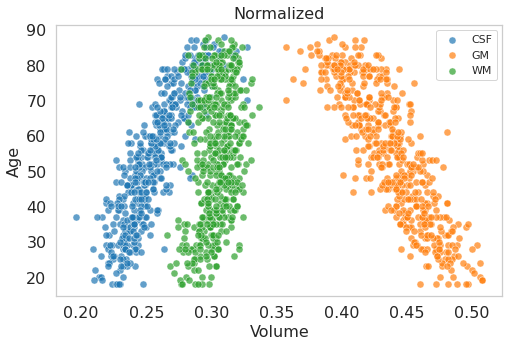

In [45]:
# plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
# plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
# plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
# plt.grid()
# plt.title('Normalised')
# plt.xlabel('Volume')
# plt.ylabel('Age')
# plt.legend(('CSF','GM','WM'))
# plt.show()


import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(x=vols_normalised[0,:], y=meta_data_reg_train['age'], marker='o', s=50, alpha=0.7, ax=ax)
sns.scatterplot(x=vols_normalised[1,:], y=meta_data_reg_train['age'],marker='o', s=50, alpha=0.7, ax=ax)
sns.scatterplot(x=vols_normalised[2,:], y=meta_data_reg_train['age'], marker='o', s=50, alpha=0.7, ax=ax)

ax.grid()
ax.set_title('Normalized',fontsize=16)
ax.set_xlabel('Volume',fontsize=16)
ax.set_ylabel('Age',fontsize=16)
ax.legend(labels=('CSF', 'GM', 'WM'))
# ax.set_xticks(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

Final data for age regression

In [83]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [47]:
########################################
# ADD YOUR CODE HERE
########################################
# Import the packages


import pandas as pd
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC  

k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=rnd_seed)

lr_preds = []
knn_preds = []
ridge_preds = []
mlp_preds = []
ls_preds = []
stored_predictions=[lr_preds,knn_preds,ridge_preds,mlp_preds,ls_preds]

y_two_fold_val = []

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=4, algorithm='auto'),
    'Lasso Lars':LassoLars(alpha=0.1)
    ,
    'Bayesian Ridge': make_pipeline(StandardScaler(with_mean=False), BayesianRidge()),
    'Lasso': Lasso(alpha=0.2)
}

mae_scores_fold_1 = []
mae_scores_fold_2=[]

for i, (train_index, val_index) in enumerate(kf.split(X)):
    
    x_train = X[train_index].reshape(len(train_index), -1)
    x_val = X[val_index].reshape(len(val_index), -1)
    y_train = y[train_index].ravel()
    y_val = y[val_index].ravel()
    y_two_fold_val.append(y_val)
    
    for j,(name, model) in enumerate(models.items()):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        stored_predictions[j].append(y_pred)
        mae = np.round(mean_absolute_error(y_val, y_pred), 5)

        #check model fit on train data
        y_pred_train=model.predict(x_train)
        mae_train=np.round(mean_absolute_error(y_train, y_pred_train), 5)
        r2_train=np.round(r2_score(y_train, y_pred_train), 5)

        r2 = np.round(r2_score(y_val, y_pred), 5)
        if i==0:
          mae_scores_fold_1.append({'Model': name,"MAe_train":mae_train ,'MAE_test': mae,'R2_train': r2_train, 'R2_test': r2})
        elif i==1:
          mae_scores_fold_2.append({'Model': name,"MAe_train":mae_train ,'MAE_test': mae,'R2_train': r2_train, 'R2_test': r2})


df_mae_scores_1 = pd.DataFrame(mae_scores_fold_1)
df_mae_scores_2 = pd.DataFrame(mae_scores_fold_2)

print('Summary stats for fold 1')
display(df_mae_scores_1)

print('Summary stats for fold 2')

display(df_mae_scores_2)





Summary stats for fold 1


,Model,MAe_train,MAE_test,R2_train,R2_test
0,Linear Regression,7.18100,7.01300,0.77377,0.76129
1,KNN,5.31400,7.05100,0.87017,0.74211
2,Lasso Lars,7.35868,7.20581,0.76668,0.75622
3,Bayesian Ridge,7.18019,7.02623,0.77406,0.75993
4,Lasso,9.85166,9.80503,0.60591,0.59162


Summary stats for fold 2


,Model,MAe_train,MAE_test,R2_train,R2_test
0,Linear Regression,7.02569,7.31812,0.76815,0.76754
1,KNN,5.53600,7.34500,0.84609,0.75223
2,Lasso Lars,7.21097,7.55269,0.76017,0.75767
3,Bayesian Ridge,7.02744,7.31727,0.76813,0.76762
4,Lasso,10.33493,10.39713,0.55443,0.56256


Error calculation and plotting

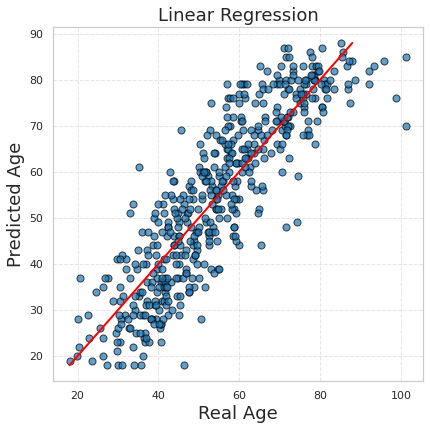

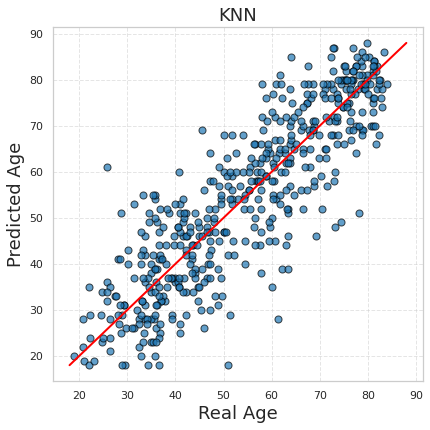

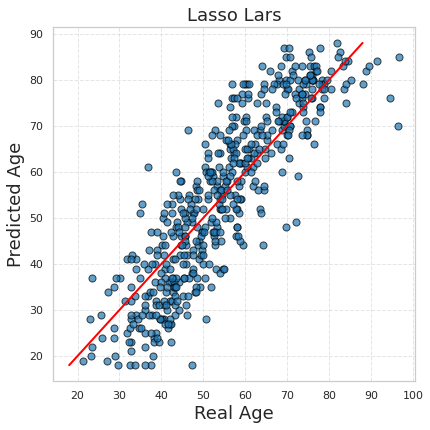

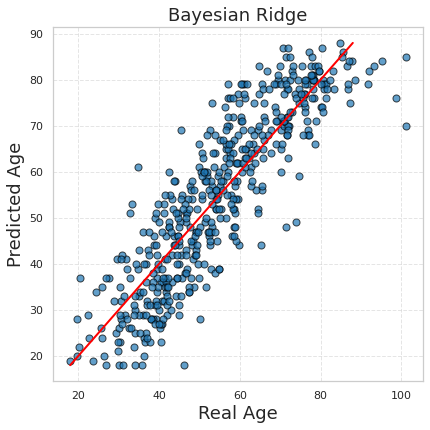

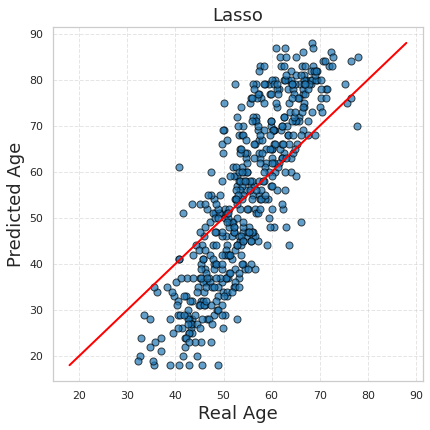

In [48]:
#All models
model_names=list(models.keys())

for i,name in enumerate(model_names):
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.scatter(stored_predictions[i], y_two_fold_val, marker='o', s=50, alpha=0.7, edgecolors='k')
  ax.plot([np.min(y_two_fold_val), np.max(y_two_fold_val)], [np.min(y_two_fold_val), np.max(y_two_fold_val)], 'r-', lw=2)
  ax.set_xlabel('Real Age', fontsize=18)
  ax.set_ylabel('Predicted Age', fontsize=18)
  ax.set_title(model_names[i], fontsize=18)
  ax.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout(pad=2)
  plt.show()





### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [49]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-02-27 08:43:29--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-test-data.zip.1’

brainage-test-data. 100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-02-27 08:43:30 (274 MB/s) - ‘brainage-test-data.zip.1’ saved [1521/1521]

Archive:  brainage-test-data.zip
replace data/brain_age/meta/meta_data_regression_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Loading and pre-processing of testing data

In [50]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


#### Run final testing

In [51]:
########################################
# ADD YOUR CODE HERE
########################################

pred_dir = os.path.join(out_dir, 'held_out_test_pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D_modified(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('Start...')

with torch.no_grad():
    for idx_test, data_sample in enumerate(dataloader_test):

        img = data_sample['img'].to(device)
        prd = model(img)
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))

print('Completed!')

Start...
Completed!


### Unormalized features

In [52]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')

ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [pred_dir +  '/sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

vols = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]

    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################

        seg_array = sitk.GetArrayFromImage(seg)

        unique, counts = np.unique(seg_array, return_counts=True)
        counts_dict = dict(zip(unique, counts))
      
        vols[0, idx] = counts_dict[1]
        vols[1, idx] = counts_dict[2]
        vols[2, idx] = counts_dict[3]
        
      

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 150.06it/s]


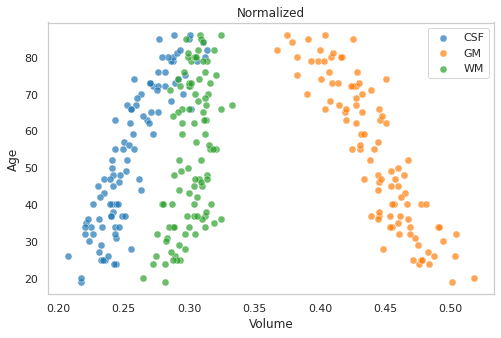

In [53]:
#  RELATIVE TISSUE VOLUMES

volumns_normalised = np.zeros((3,len(files_reg_seg_test)))

for i in range(len(vols[0])):
  volumns_normalised[0, i] = vols[0, i] /  np.sum(vols, axis=0)[i]
  volumns_normalised[1, i] = vols[1, i] /  np.sum(vols, axis=0)[i]
  volumns_normalised[2, i] = vols[2, i] /  np.sum(vols, axis=0)[i]

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

# sns.scatterplot(x=volumns_normalised[0,:], y=meta_data_reg_test['age'], marker='o', s=50, alpha=0.7, ax=ax)
# sns.scatterplot(x=volumns_normalised[1,:], y=meta_data_reg_test['age'],marker='o', s=50, alpha=0.7, ax=ax)
# sns.scatterplot(x=volumns_normalised[2,:], y=meta_data_reg_test['age'], marker='o', s=50, alpha=0.7, ax=ax)

sns.scatterplot(x=volumns_normalised[0,:], y=meta_data_reg_test['age'],  s=50, alpha=0.7, ax=ax)
sns.scatterplot(x=volumns_normalised[1,:], y=meta_data_reg_test['age'], s=50, alpha=0.7, ax=ax)
sns.scatterplot(x=volumns_normalised[2,:], y=meta_data_reg_test['age'],  s=50, alpha=0.7, ax=ax)

ax.grid()
ax.set_title('Normalized')
ax.set_xlabel('Volume')
ax.set_ylabel('Age')
ax.legend(labels=('CSF', 'GM', 'WM'))

plt.show()

In [54]:
#Process the X and y test data
X_test = volumns_normalised.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

print(X_test.shape)
print(y_test.shape)

(100, 3)
(100, 1)


## Make prediction

MAE on unseen test set: 7.1775
r2 on unseen test set: 0.8013


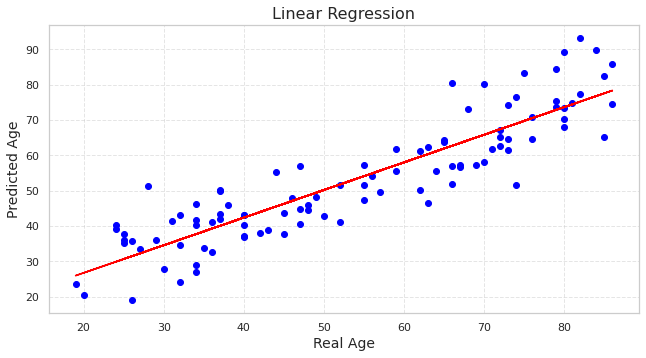

In [109]:
# Prediction

from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars,Lasso

linear=LinearRegression()
linear.fit(X,y.ravel())

y_pred = linear.predict(X_test)
mae = np.round(mean_absolute_error(y_test, y_pred), 5)
r2=np.round(r2_score(y_test, y_pred), 5)
print(f'MAE on unseen test set: {mae}')
print(f'r2 on unseen test set: {r2}')

plt.figure(figsize=(10,6))
plt.title('Predictions vs actual')
plt.scatter(y_test, y_pred,color='blue',marker='o')
plt.xlabel('Real Age', fontsize=14)
plt.ylabel('Predicted Age', fontsize=14)
plt.title("Linear Regression", fontsize=16)





plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(pad=2)

y_test_list=[]
y_pred_list=[]
for i in range(100):
  y_test_list.append((y_test.tolist()[i]))
  y_pred_list.append(y_pred.tolist()[i])

y_test_list=np.array(y_test_list)
m, b = np.polyfit(y_test_list, y_pred, 1)
plt.plot(y_test_list, m*y_test+b, color='red')


plt.show()


## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################
# import all required libraries
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np



## Hyperparameters for Cross Validation Training

In [ ]:
### Defining Hyperparameters - to be tuned
rnd_seed = 42 #fixed random seed same as above Part A

img_size = [84, 84, 84] # trying higher resolution pictures
img_spacing = [3, 3, 3]

num_epochs = 40
learning_rate = 1e-3
batch_size = 16
k = 2 # do not change this as per CW specs

# Parameters for Testing & Logging:
val_interval = 5

# num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
### Creating a class for Part B Age Regression using NN
class AgeRegDataset(Dataset):
    """Dataset for PartB Age Regression using NN"""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size, ages):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            age = ages[idx]

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = torch.from_numpy(np.array(sample['age'], dtype=np.float32))


        return {'img': image, 'seg': seg, 'msk': msk, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

## Datasets for Cross Validation

In [ ]:
### Splitting data sets for 2 fold cross-validation
from sklearn.model_selection import train_test_split

# Cross validation datasets
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
age = meta_data_reg_train['age']
mean, std = np.mean(age), np.sqrt(np.var(age))
norm_age = (age - mean)/std
ids_seg_train1, ids_seg_train2, labels1, labels2 = train_test_split(list(meta_data_reg_train['subject_id']),
                                                 norm_age,
                                                 test_size=0.5,
                                                 shuffle=True)
labels1 = np.array(labels1)
labels2 = np.array(labels2)

# fold1
files_seg_img_train1 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train1]
files_seg_seg_train1 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train1]
files_seg_msk_train1 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train1]

dataset_train1 = AgeRegDataset(files_seg_img_train1, files_seg_seg_train1, files_seg_msk_train1,
                                     img_spacing, img_size, labels1)
dataloader_train1 = torch.utils.data.DataLoader(dataset_train1, batch_size=batch_size, shuffle=True)

# fold2
files_seg_img_train2 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train2]
files_seg_seg_train2 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train2]
files_seg_msk_train2 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train2]

dataset_train2 = AgeRegDataset(files_seg_img_train2, files_seg_seg_train2, files_seg_msk_train2,
                                     img_spacing, img_size, labels2)
dataloader_train2 = torch.utils.data.DataLoader(dataset_train2, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 250/250 [00:27<00:00,  8.98it/s]


## CNN Model


In [ ]:
class AgePredict(nn.Module):
    def __init__(self):
        super(AgePredict, self).__init__()
        
        self.net = nn.Sequential(
            
            nn.Conv3d(1, 8, kernel_size=3, bias=False), #img size 84 --> 82
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2),  #img size 82 --> 41
            
            nn.Conv3d(8, 32, kernel_size=3, bias=False), #img size 41 -->39 
            nn.LeakyReLU(),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=2), #img size 39 --> 19
            
            nn.Conv3d(32, 64, kernel_size=3, bias=False), #img size 19 --> 17 
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.MaxPool3d(kernel_size=2),#img size 17 --> 8
            
            nn.Conv3d(64, 128, kernel_size=3, bias=False),  #img size 8 --> 6
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.MaxPool3d(kernel_size=2), #img size 6 --> 3
            
            nn.Conv3d(128, 256, kernel_size=2, bias=False),  #img size 3 --> 2
            nn.LeakyReLU(),
            nn.BatchNorm3d(256),
            nn.MaxPool3d(kernel_size= 2), #img size 2 --> 1

           
        )
        

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, 1)


    def forward(self, x):
        
        x = self.net(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        
        return out

In [ ]:
# Weights initialisation - standard set of initilisation parameter values
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# Defining Loss 
loss_function = nn.MSELoss()

## Training Loop for Cross Validation

In [ ]:
#for logging overall losses
overall_train_loss_list = []
overall_train_mae_list = []
overall_val_loss_list = []
overall_val_mae_list = []
overall_val_epoch_list = []

# Training and validation loop:
for i in range(k):
    #initialise model
    model = AgePredict()
    #apply weights and print no. of params
    model.apply(weights_init)
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total number of parameters: {}".format(params))
    model = model.to(device)
    #optimizer set up - can be tuned later the type of optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # k-fold validation (k=2)
    if i==0:
        print('Training: Fold 1, Validating: Fold 2')
        dataloader_train = dataloader_train1
        dataloader_val = dataloader_train2 
    else:
        print('Training: Fold 2, Validating: Fold 1')
        dataloader_train = dataloader_train2
        dataloader_val = dataloader_train1 

    train_loss_list = []
    train_mae_list = []
    val_loss_list = []
    val_mae_list = []
    val_epoch_list = [] 

### Training starts here! ###
    for epoch in range (1, num_epochs+1):
        model.train()
        epoch_loss = 0
        epoch_mae = 0
        for idx, batch in enumerate(dataloader_train):
            # imgs, labels = batch['img'], batch['age'].to(dtype=torch.float32)
            imgs = batch['img'].to(device)
            labels = batch['age'].to(dtype=torch.float32).to(device)

            optimizer.zero_grad()
            predictions = model(imgs).squeeze()
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()

            # Logging Losses over the epoch for TRAIN
            epoch_loss += loss.item()
            unnorm_ages = (labels*std+mean).detach().cpu().numpy()
            unnorm_predictions = (predictions*std+mean).detach().cpu().numpy()
            epoch_mae += np.mean(np.abs(unnorm_ages - unnorm_predictions))

        # Logging Losses at end of epoch for TRAIN 
        epoch_loss = epoch_loss/(idx+1)
        epoch_mae = epoch_mae/(idx+1)
        print(f'+ TRAINING \tEpoch: {epoch} \tLoss: {epoch_loss} \tMAE: {epoch_mae}')
        train_loss_list.append(epoch_loss)
        train_mae_list.append(epoch_mae)

        ### Validation starts here! ###
        if epoch == 1 or epoch % val_interval == 0:
            model.eval()
            epoch_loss = 0 
            epoch_mae = 0

            for idx, batch in enumerate(dataloader_val):
                imgs = batch['img'].to(device)
                labels = batch['age'].to(dtype=torch.float32).to(device)
                predictions = model(imgs).squeeze()
                loss = loss_function(predictions, labels)

                # Logging Losses over the epoch for VALIDATION
                epoch_loss += loss.item()
                unnorm_ages = (labels*std+mean).detach().cpu().numpy()
                unnorm_predictions = (predictions*std+mean).detach().cpu().numpy()
                epoch_mae += np.mean(np.abs(unnorm_ages - unnorm_predictions))

            # Logging Losses at end of epoch for VALIDATION 
            epoch_loss = epoch_loss/(idx+1)
            epoch_mae = epoch_mae/(idx+1)
            print(f'+ VALIDATION \tEpoch: {epoch} \tLoss: {epoch_loss} \tMAE: {epoch_mae}')
            val_loss_list.append(epoch_loss)
            val_mae_list.append(epoch_mae)
            val_epoch_list.append(epoch)
  
    overall_train_loss_list.append(train_loss_list)
    overall_train_mae_list.append(train_mae_list)
    overall_val_loss_list.append(val_loss_list)
    overall_val_mae_list.append(val_mae_list)
    overall_val_epoch_list.append(val_epoch_list)

  # pickle the files for easy ref without having to re-run model

import pickle
with open("overall_train_loss_list.txt", "wb") as f:
    pickle.dump(overall_train_loss_list, f)
with open("overall_train_mae_list.txt", "wb") as f:
    pickle.dump(overall_train_mae_list, f)
with open("overall_val_loss_list.txt", "wb") as f:
    pickle.dump(overall_val_loss_list, f)
with open("overall_val_mae_list.txt", "wb") as f:
    pickle.dump(overall_val_mae_list, f)
with open("overall_val_epoch_list.txt", "wb") as f:
    pickle.dump(overall_val_epoch_list, f)


  



Total number of parameters: 546985
Training: Fold 1, Validating: Fold 2
+ TRAINING 	Epoch: 1 	Loss: 0.8407401498407125 	MAE: 13.097070515155792
+ VALIDATION 	Epoch: 1 	Loss: 6.439002245664597 	MAE: 43.04042363166809
+ TRAINING 	Epoch: 2 	Loss: 0.39391190465539694 	MAE: 9.224799245595932
+ TRAINING 	Epoch: 3 	Loss: 0.3001715177670121 	MAE: 8.317582875490189
+ TRAINING 	Epoch: 4 	Loss: 0.16695828968659043 	MAE: 6.082304418087006
+ TRAINING 	Epoch: 5 	Loss: 0.13135258725378662 	MAE: 5.358652293682098
+ VALIDATION 	Epoch: 5 	Loss: 1.494542170315981 	MAE: 18.27513712644577
+ TRAINING 	Epoch: 6 	Loss: 0.1253294178750366 	MAE: 5.337662994861603
+ TRAINING 	Epoch: 7 	Loss: 0.06435192318167537 	MAE: 3.8102405071258545
+ TRAINING 	Epoch: 8 	Loss: 0.06400160805787891 	MAE: 3.741267643868923
+ TRAINING 	Epoch: 9 	Loss: 0.14389337447937578 	MAE: 5.819547191262245
+ TRAINING 	Epoch: 10 	Loss: 0.2607465903274715 	MAE: 7.644564315676689
+ VALIDATION 	Epoch: 10 	Loss: 0.31819136440753937 	MAE: 8.639021

In [ ]:
# import pickle files if needed (don't want to run training again)
import pickle
with open("overall_train_loss_list.txt", "rb") as f:
    overall_train_loss_list = pickle.load(f)
with open("overall_train_mae_list.txt", "rb") as f:
    overall_train_mae_list = pickle.load(f)
with open("overall_val_loss_list.txt", "rb") as f:
    overall_val_loss_list = pickle.load(f)
with open("overall_val_mae_list.txt", "rb") as f:
    overall_val_mae_list = pickle.load(f)
with open("overall_val_epoch_list.txt", "rb") as f:
    overall_val_epoch_list = pickle.load(f)



### Plot graphs for cross validation

Loss and MAE Fold 1: Train & Fold 2: Val


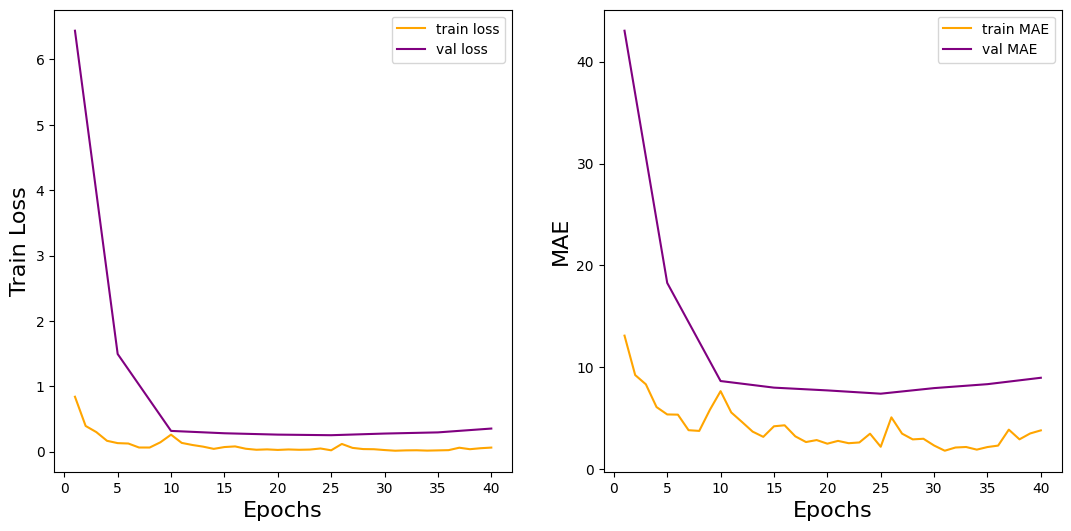

Loss and MAE Fold 2: Train & Fold 1: Val


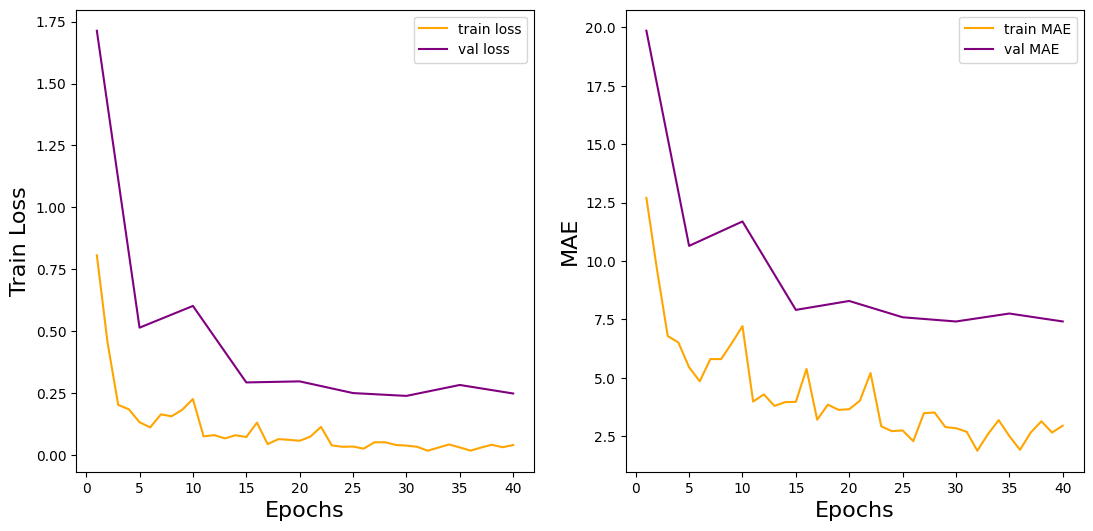

In [ ]:
train_epoch_list = range(1,num_epochs+1)
## Loss curves plotting

for i in range(1, k+1):
    if i == 1:
        j=2
    else: j=1

    print(f"Loss and MAE Fold {i}: Train & Fold {j}: Val")
    fig, axes = plt.subplots(1,2, figsize=(13,6))
    ax = axes[0]
    ax.plot(train_epoch_list, overall_train_loss_list[i-1], 'orange', label='train loss')
    ax.plot(overall_val_epoch_list[i-1], overall_val_loss_list[i-1], 'purple', label='val loss')
    ax.set_xlabel('Epochs', fontsize=16)
    ax.set_ylabel('Train Loss', fontsize=16)
    ax.legend(loc='upper right')

    ax = axes[1]
    ax.plot(train_epoch_list, overall_train_mae_list[i-1], 'orange', label='train MAE')
    ax.plot(overall_val_epoch_list[i-1], overall_val_mae_list[i-1], 'purple', label='val MAE')
    ax.set_xlabel('Epochs',fontsize=16)
    ax.set_ylabel('MAE', fontsize=16)
    ax.legend(loc='upper right')
    plt.show()                                


## Load full data set for test set for performance check!

In [ ]:
# Training dataset
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
age = meta_data_reg_train['age']
mean, std = np.mean(age), np.sqrt(np.var(age))
norm_age = (age - mean)/std
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train= [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

dataset_train = AgeRegDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size, norm_age)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation dataset
meta_data_reg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
age = meta_data_reg_val['age']
norm_age = (age - mean)/std
ids_seg_val = list(meta_data_reg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

dataset_val = AgeRegDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size, norm_age)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=2, shuffle=True)




Loading Data: 100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


## **Training with Full Training Data Set!**



In [ ]:
# Final parameters for model to use
rnd_seed = 42 #fixed random seed same as above Part A

num_epochs = 40
learning_rate = 1e-3
batch_size = 16
k = 2 # do not change this as per CW specs

# Parameters for Testing & Logging:
val_interval = 1


partb_dir = './Part_B'

out_dir = './output'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)


if not os.path.exists(partb_dir):
    os.makedirs(partb_dir)



In [ ]:
# Weights initialisation - standard set of initilisation parameter values
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# Defining Loss 
loss_function = nn.MSELoss()

In [ ]:
#initialise model
model = AgePredict()
#apply weights and print no. of params
model.apply(weights_init)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: {}".format(params))
model = model.to(device)
#optimizer set up - can be tuned later the type of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list = []
train_mae_list = []
val_loss_list = []
val_mae_list = []
val_epoch_list = [] 

### Training starts here! ###
for epoch in range (1, num_epochs+1):
    model.train()
    epoch_loss = 0
    epoch_mae = 0
    for idx, batch in enumerate(dataloader_train):
        imgs = batch['img'].to(device)
        labels = batch['age'].to(dtype=torch.float32).to(device)

        optimizer.zero_grad()
        predictions = model(imgs).squeeze()
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        # Logging Losses over the epoch for TRAIN
        epoch_loss += loss.item()
        unnorm_ages = (labels*std+mean).detach().cpu().numpy()
        unnorm_predictions = (predictions*std+mean).detach().cpu().numpy()
        epoch_mae += np.mean(np.abs(unnorm_ages - unnorm_predictions))

    # Logging Losses at end of epoch for TRAIN 
    epoch_loss = epoch_loss/(idx+1)
    epoch_mae = epoch_mae/(idx+1)
    print(f'+ TRAINING \tEpoch: {epoch} \tLoss: {epoch_loss} \tMAE: {epoch_mae}')
    train_loss_list.append(epoch_loss)
    train_mae_list.append(epoch_mae)

    ### Validation starts here! ###
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()
        epoch_loss = 0 
        epoch_mae = 0

    for idx, batch in enumerate(dataloader_val):
        imgs = batch['img'].to(device)
        labels = batch['age'].to(dtype=torch.float32).to(device)
        predictions = model(imgs).squeeze(1)
        loss = loss_function(predictions, labels)

        # Logging Losses over the epoch for VALIDATION
        epoch_loss += loss.item()
        unnorm_ages = (labels*std+mean).detach().cpu().numpy()
        unnorm_predictions = (predictions*std+mean).detach().cpu().numpy()
        epoch_mae += np.mean(np.abs(unnorm_ages - unnorm_predictions))

    # Logging Losses at end of epoch for TRAIN 
    epoch_loss = epoch_loss/(idx+1)
    epoch_mae = epoch_mae/(idx+1)
    print(f'+ VALIDATION \tEpoch: {epoch} \tLoss: {epoch_loss} \tMAE: {epoch_mae}')
    val_loss_list.append(epoch_loss)
    val_mae_list.append(epoch_mae)
    val_epoch_list.append(epoch)
  


# pickle the files for easy ref without having to re-run model
  
import pickle
with open("train_loss_list.txt", "wb") as f:
    pickle.dump(train_loss_list, f)
with open("train_mae_list.txt", "wb") as f:
    pickle.dump(train_mae_list, f)
with open("val_loss_list.txt", "wb") as f:
    pickle.dump(val_loss_list, f)
with open("val_mae_list.txt", "wb") as f:
    pickle.dump(val_mae_list, f)
with open("val_epoch_list.txt", "wb") as f:
    pickle.dump(val_epoch_list, f)



  



Total number of parameters: 546985
+ TRAINING 	Epoch: 1 	Loss: 0.6219659955240786 	MAE: 11.306851536035538
+ VALIDATION 	Epoch: 1 	Loss: 73.0052981376648 	MAE: 156.54267183939615
+ TRAINING 	Epoch: 2 	Loss: 0.3944737990386784 	MAE: 9.254271358251572
+ VALIDATION 	Epoch: 2 	Loss: 134.39918835957846 	MAE: 211.15106646219888
+ TRAINING 	Epoch: 3 	Loss: 0.23931660689413548 	MAE: 7.320846900343895
+ VALIDATION 	Epoch: 3 	Loss: 0.22603160661431806 	MAE: 6.958285649617513
+ TRAINING 	Epoch: 4 	Loss: 0.27823390648700297 	MAE: 7.6513461992144585
+ VALIDATION 	Epoch: 4 	Loss: 0.39366201621790725 	MAE: 9.702266057332357
+ TRAINING 	Epoch: 5 	Loss: 0.16853487596381456 	MAE: 6.032325096428394
+ VALIDATION 	Epoch: 5 	Loss: 0.2220115658613698 	MAE: 6.7671323617299395
+ TRAINING 	Epoch: 6 	Loss: 0.15961500018602237 	MAE: 5.761311836540699
+ VALIDATION 	Epoch: 6 	Loss: 0.18560931187433502 	MAE: 6.479153672854106
+ TRAINING 	Epoch: 7 	Loss: 0.15790378639940172 	MAE: 5.84582257270813
+ VALIDATION 	Epoch:

In [ ]:
torch.save(model.state_dict(), os.path.join(partb_dir, 'final_model.pt'))


Loss and MAE for full training data


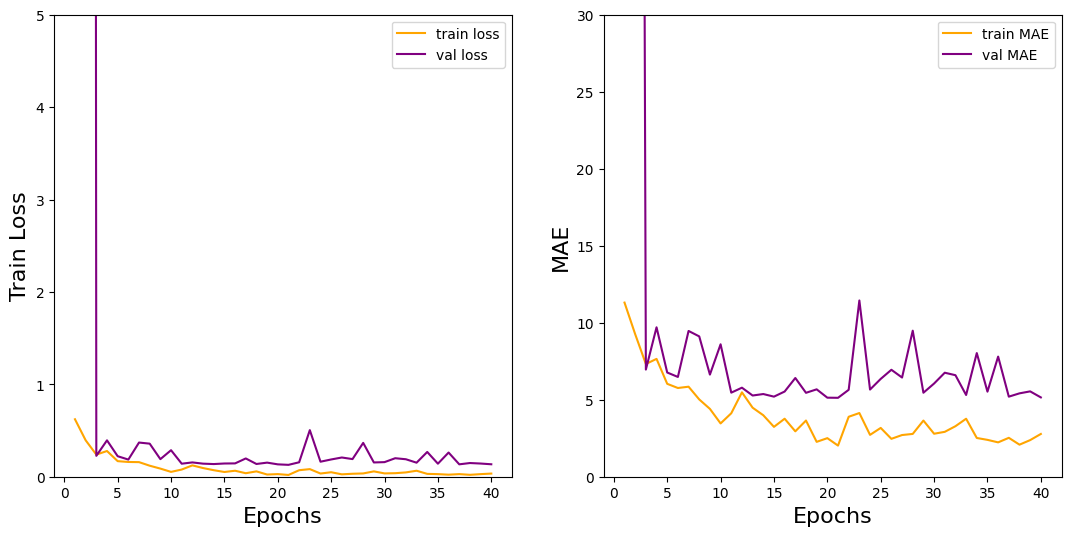

In [ ]:
#plot graph for model training and validation with full data set
train_epoch_list = range(1,num_epochs+1)
print(f"Loss and MAE for full training data")
fig, axes = plt.subplots(1,2, figsize=(13,6))
ax = axes[0]
ax.plot(train_epoch_list, train_loss_list, 'orange', label='train loss')
ax.plot(val_epoch_list, val_loss_list, 'purple', label='val loss')
ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Train Loss', fontsize=16)
ax.set_ylim(0,5)
ax.legend(loc='upper right')

ax = axes[1]
ax.plot(train_epoch_list, train_mae_list, 'orange', label='train MAE')
ax.plot(val_epoch_list, val_mae_list, 'purple', label='val MAE')
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.set_ylim(0,30)
ax.legend(loc='upper right')
plt.show()     

## Final Testing held-out samples!!!

In [ ]:
# Testing dataset 
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
age = meta_data_reg_test['age']
norm_age = (age-mean)/std
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = AgeRegDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size, norm_age)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


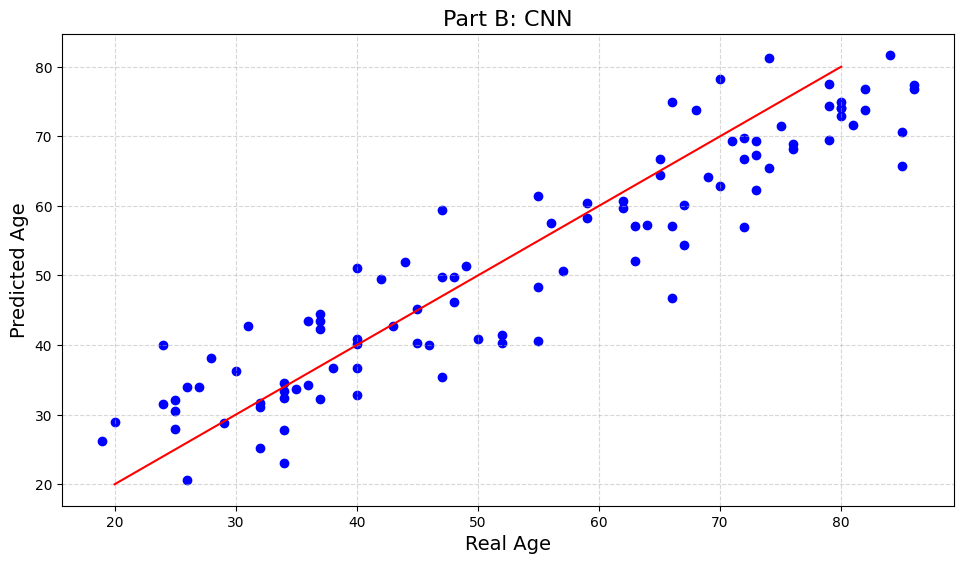

+ TEST	Loss: 0.1699887157266494 	MAE: 6.354803290367126


In [ ]:
model = AgePredict()
model.load_state_dict(torch.load(os.path.join(partb_dir, 'final_model.pt')))
model.to(device)
model.eval()

# Scatter plot
plt.figure(figsize=(10,6))
plt.title('Predictions vs actual')
plt.xlabel('Real Age', fontsize=14)
plt.ylabel('Predicted Age', fontsize=14)
plt.title("Part B: CNN", fontsize=16)
x= [20, 80]
y = [20, 80]
plt.plot(x,y, color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(pad=2)


for idx, batch in enumerate(dataloader_test):

    # Predict
    imgs = batch['img'].to(device)
    labels = batch['age'].to(dtype=torch.float32).to(device)  
    predictions = model(imgs).squeeze()
    loss = loss_function(predictions, labels)

    # Save loss
    epoch_loss += loss.item()
    unnorm_ages = (labels*std+mean).detach().cpu().numpy()
    unnorm_predictions = (predictions*std+mean).detach().cpu().numpy()
    epoch_mae += np.mean(np.abs(unnorm_ages-unnorm_predictions))

    # Plot predictions versus true ages
    plt.scatter(unnorm_ages, unnorm_predictions, color='blue')
    
plt.show()
epoch_loss = epoch_loss/(idx+1)
epoch_mae = epoch_mae/(idx+1)
print(f'+ TEST\tLoss: {epoch_loss} \tMAE: {epoch_mae}')